In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [5]:
df = pd.read_csv('retail_store_inventory.csv')
df

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,2024-01-01,S005,P0016,Furniture,East,96,8,127,18.46,73.73,20,Snowy,0,72.45,Winter
73096,2024-01-01,S005,P0017,Toys,North,313,51,101,48.43,82.57,10,Cloudy,0,83.78,Autumn
73097,2024-01-01,S005,P0018,Clothing,West,278,36,151,39.65,11.11,10,Rainy,0,10.91,Winter
73098,2024-01-01,S005,P0019,Toys,East,374,264,21,270.52,53.14,20,Rainy,0,55.80,Spring


In [6]:
df.columns = df.columns.str.strip()  # Remove extra spaces
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df = df.sort_values('Date')

print("✅ Data loaded successfully!")
print(df[['Date', 'Units Sold']].head())

✅ Data loaded successfully!
         Date  Units Sold
0  2022-01-01         127
72 2022-01-01          56
71 2022-01-01           9
70 2022-01-01          46
69 2022-01-01         104


In [7]:
df['Units Sold'] = pd.to_numeric(df['Units Sold'], errors='coerce')
df = df.dropna(subset=['Units Sold'])
df = df[df['Units Sold'] > 0]

print("✅ Cleaned 'Units Sold'. Remaining rows:", len(df))

✅ Cleaned 'Units Sold'. Remaining rows: 72740


✅ Time series prepared. Shape: (731,)


C:\Users\durwa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


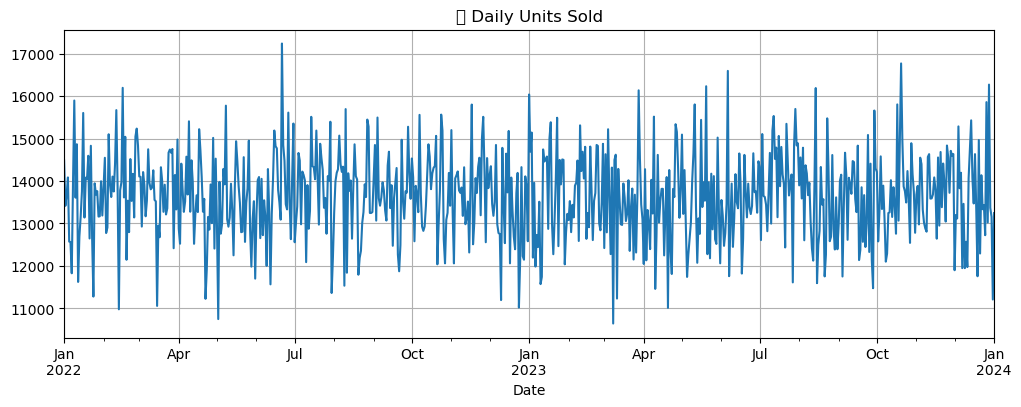

In [8]:
daily_sales = df.groupby('Date')['Units Sold'].sum()
daily_sales = daily_sales.asfreq('D')  # Ensure daily frequency
daily_sales = daily_sales.replace([np.inf, -np.inf], np.nan)
daily_sales = daily_sales.fillna(method='ffill')  # Fill missing values forward

# Check time series health
if daily_sales.dropna().empty:
    raise ValueError("❌ Time series is empty after cleaning.")
elif daily_sales.nunique() == 1:
    raise ValueError("❌ Time series is constant. Forecasting will fail.")
else:
    print("✅ Time series prepared. Shape:", daily_sales.shape)

daily_sales.plot(figsize=(12,4), title='🕒 Daily Units Sold')
plt.grid(True)
plt.show()

In [9]:
adf_stat, p_val, _, _, _, _ = adfuller(daily_sales.dropna())
print("✅ ADF Statistic:", round(adf_stat, 4))
print("✅ p-value:", round(p_val, 4))

if p_val < 0.05:
    print("✔️ Time series is stationary")
else:
    print("❌ Time series is not stationary")

✅ ADF Statistic: -26.3795
✅ p-value: 0.0
✔️ Time series is stationary


C:\Users\durwa\AppData\Local\Temp\ipykernel_7244\1803388281.py:4: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout()
C:\Users\durwa\AppData\Local\Temp\ipykernel_7244\1803388281.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\durwa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


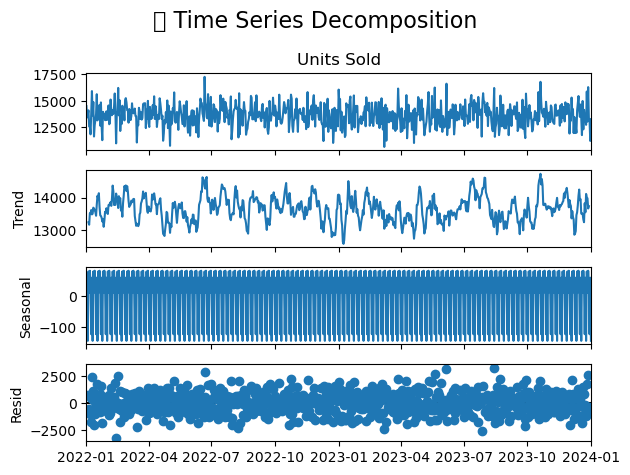

In [10]:
decomposition = seasonal_decompose(daily_sales, model='additive', period=7)
decomposition.plot()
plt.suptitle("🧠 Time Series Decomposition", fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
train = daily_sales[:-30]
test = daily_sales[-30:]

print("✅ Train size:", len(train))
print("✅ Test size:", len(test))

✅ Train size: 701
✅ Test size: 30


In [14]:
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7),
                enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)

print("✅ SARIMA model fitted successfully.")

✅ SARIMA model fitted successfully.


In [15]:
forecast = results.get_forecast(steps=30)
predicted = forecast.predicted_mean
conf_int = forecast.conf_int()
conf_int.columns = ['lower_bound', 'upper_bound']

print("✅ Forecast done. Here's a preview:")
print(predicted.head())

✅ Forecast done. Here's a preview:
2023-12-03    13705.549221
2023-12-04    13502.325006
2023-12-05    13732.909415
2023-12-06    13702.658000
2023-12-07    13670.375067
Freq: D, Name: predicted_mean, dtype: float64


C:\Users\durwa\AppData\Local\Temp\ipykernel_7244\1037494450.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\durwa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


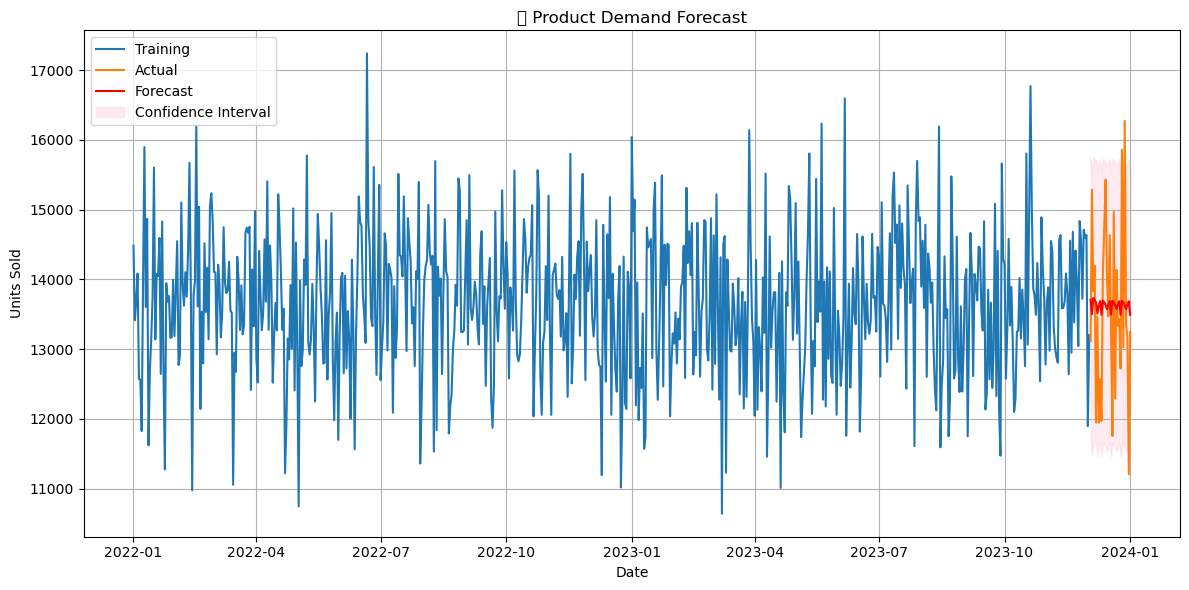

In [16]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual')
plt.plot(predicted.index, predicted, color='red', label='Forecast')
plt.fill_between(predicted.index, conf_int['lower_bound'], conf_int['upper_bound'],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title("📊 Product Demand Forecast")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
rmse = np.sqrt(mean_squared_error(test, predicted))
print("📉 Root Mean Squared Error (RMSE):", round(rmse, 2))

📉 Root Mean Squared Error (RMSE): 1233.45


In [18]:
print("📅 Forecasted Demand (Next 5 Days):")
print(predicted.head())

📅 Forecasted Demand (Next 5 Days):
2023-12-03    13705.549221
2023-12-04    13502.325006
2023-12-05    13732.909415
2023-12-06    13702.658000
2023-12-07    13670.375067
Freq: D, Name: predicted_mean, dtype: float64
